# CUSTOMER CHURN PREDICTION


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
# from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout ,BatchNormalization#type:ignore
import shap

c:\Users\USER\coding_samurai\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing datasets

In [2]:
df=pd.read_csv('churn.csv')
print(df.head())
print(df.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

# Preprocessing

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges']=df['TotalCharges'].fillna(df['TotalCharges'].median())
df=df.drop('customerID',axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
cato_col=df.select_dtypes(include=['object']).columns.tolist()
cato_col.remove('Churn')
df=pd.get_dummies(df,columns=cato_col,drop_first=True,dtype=int)
df['Churn']=df['Churn'].map({'Yes':1,'No':0})
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [5]:
df['charge/tenure']=df['TotalCharges']/(df['tenure']+1)

In [6]:
x=df.drop('Churn',axis=1)
y=df['Churn']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=27,stratify=y)

In [7]:
sclr=StandardScaler()
x_train=sclr.fit_transform(x_train)
x_test=sclr.fit_transform(x_test)


# Prediction model using DNN

In [8]:
model=Sequential([
    Dense(128,activation='relu',input_shape=(x_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

c:\Users\USER\coding_samurai\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
class_weight=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weight=dict(enumerate(class_weight))

In [10]:
lr_sld=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,verbose=1)

ear_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)        

In [22]:
train=model.fit(x_train,y_train,
                validation_split=0.2,
                epochs=100,batch_size=32,
                verbose=1,class_weight=class_weight,
                callbacks=[ear_stop,lr_sld])


Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7464 - loss: 0.5051 - val_accuracy: 0.7400 - val_loss: 0.5202 - learning_rate: 2.5000e-04
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7453 - loss: 0.5026 - val_accuracy: 0.7382 - val_loss: 0.5162 - learning_rate: 2.5000e-04
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7426 - loss: 0.5046 - val_accuracy: 0.7418 - val_loss: 0.5115 - learning_rate: 2.5000e-04
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7466 - loss: 0.4925 - val_accuracy: 0.7400 - val_loss: 0.5210 - learning_rate: 2.5000e-04
Epoch 5/100
134/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7456 - loss: 0.5062
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7524 - loss: 0.4912 - val_accuracy: 0.7382 - val_loss: 0.5183 - learning_rate: 2.5000e-04
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

In [24]:
y_pred=(model.predict(x_test)>0.5).astype('int32')
y_pred

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], shape=(1409, 1), dtype=int32)

# Result

In [23]:
loss,accuracy=model.evaluate(x_test,y_test)
print(f'accuracy:{accuracy:0.2f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7388 - loss: 0.4961
accuracy:0.74


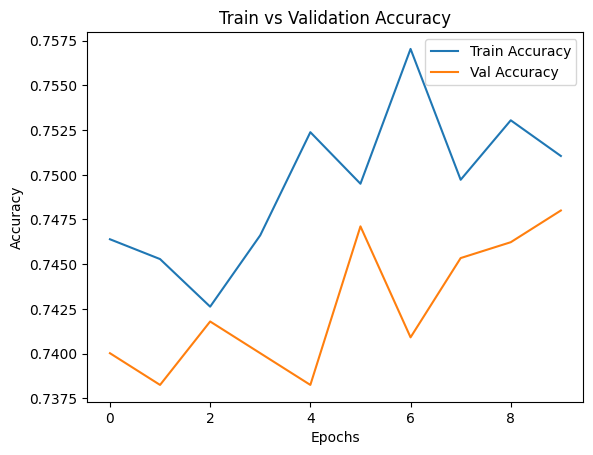

In [25]:
plt.plot(train.history['accuracy'],label='Train Accuracy')
plt.plot(train.history['val_accuracy'],label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.show()

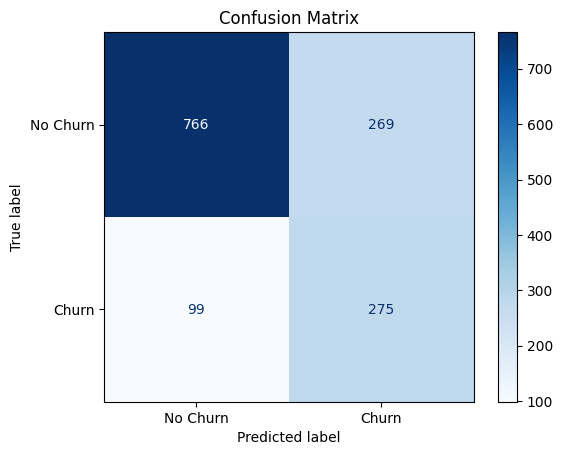

In [26]:
cm=confusion_matrix(y_test,y_pred)
display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Churn',"Churn"])
display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print("Classification Report:")
print(classification_report(y_test,y_pred,target_names=['No Churn','Churn']))

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.89      0.74      0.81      1035
       Churn       0.51      0.74      0.60       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.78      0.74      0.75      1409



PermutationExplainer explainer: 101it [00:14,  2.17it/s]                         
C:\Users\USER\AppData\Local\Temp\ipykernel_1668\3740190127.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_value,x_sam,feature_names=x.columns)


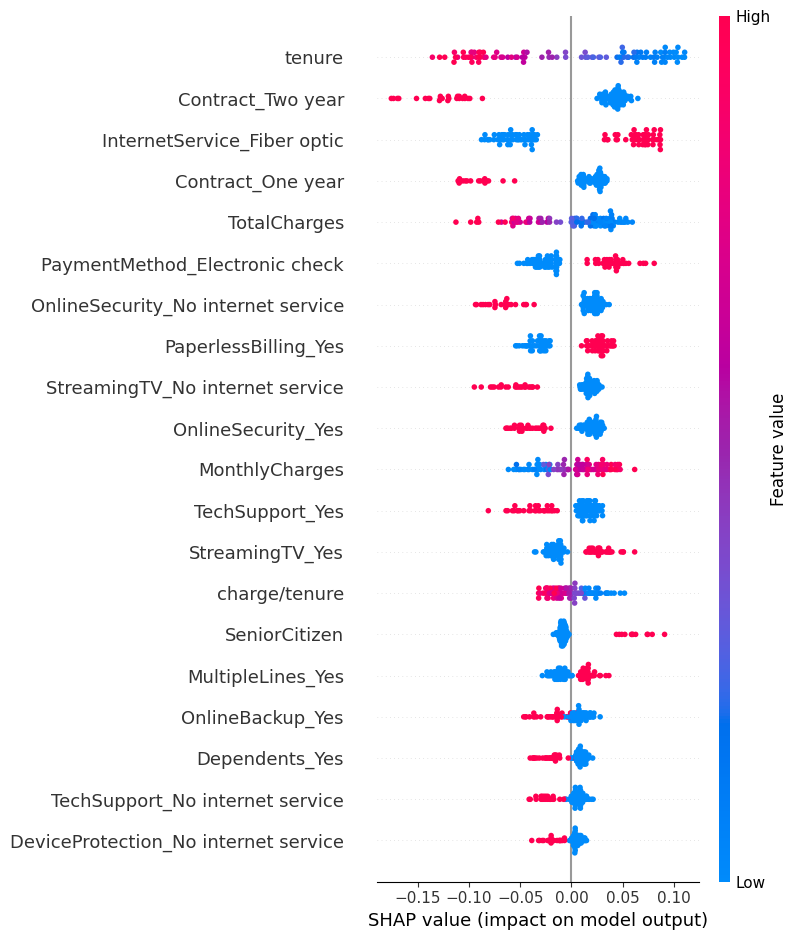

In [28]:
x_sam=x_test[:100]
explain=shap.Explainer(model,x_sam)
shap_value=explain(x_sam)
shap.summary_plot(shap_value,x_sam,feature_names=x.columns)

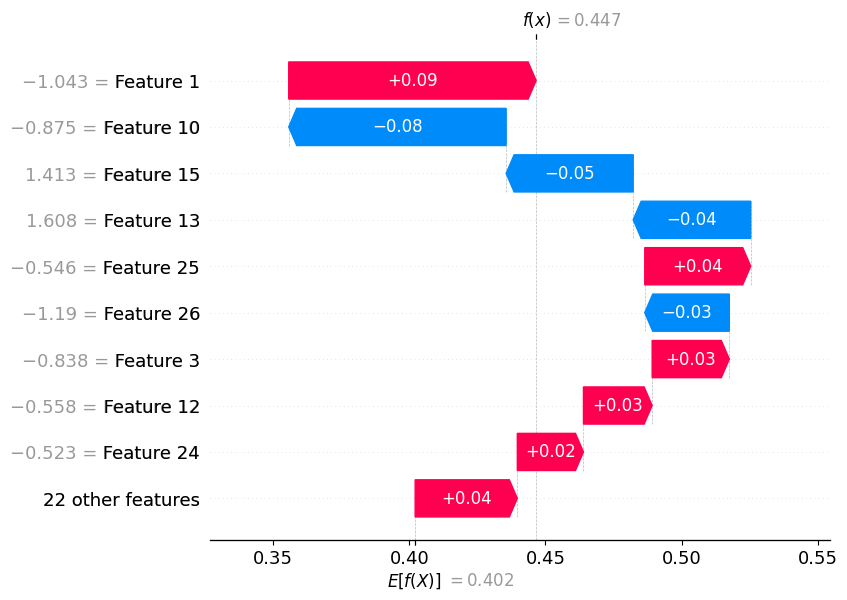

In [29]:
shap.plots.waterfall(shap_value[0])